In [1]:
from IPython.display import display

In [2]:
import numpy
import pandas
pandas.options.display.float_format = '{:,.2f}'.format
import os
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("whitegrid", rc={"lines.linewidth": .5})
import re
from sklearn import metrics

In [3]:
ITERATIONS = ['ENTITY', 'LKIF', 'YAGO']

In [4]:
FOLDS = 5

In [5]:
averages = ['micro', 'macro', 'weighted']

In [6]:
def get_input_files(input_dirpath, pattern):
    """Returns the names of the files in input_dirpath that matches pattern."""
    all_files = os.listdir(input_dirpath)
    result = []
    for filename in all_files:
        if re.match(pattern, filename) and os.path.isfile(os.path.join(
                input_dirpath, filename)):
            result.append(os.path.join(input_dirpath, filename))
    return result

In [7]:
def add_prec_rec(predictions, results, dataset_name, iteration):
    for average in averages:
        values = metrics.precision_recall_fscore_support(
            predictions.true, predictions.prediction,
            average=average, warn_for=()
        )[:3]
        columns = ['Prec({})'.format(average), 'Rec({})'.format(average), 'F1({})'.format(average)]
        results.loc[dataset_name, iteration][columns] = values

def add_top_bottom(predictions, results, dataset_name, iteration):
    if iteration == 'NER':
        return
    values = metrics.precision_recall_fscore_support(predictions.true, predictions.prediction,
                                                     average=None, warn_for=())
    values = pandas.DataFrame(numpy.vstack(values).T, columns=['Prec', 'Recall', 'F1score', 'Support'])
    to_take = int(values.shape[0] * 0.2)  # 20%
    top_values = values.sort_values('Support', ascending=False)[:to_take].mean().values[:3]
    results.loc[dataset_name, iteration][
        ['Top 20% Prec', 'Top 20% Rec', 'Top 20% F1']] = top_values
    bottom_values = values.sort_values('Support', ascending=True)[:to_take].mean().values[:3]
    results.loc[dataset_name, iteration][
        ['Bottom 20% Prec', 'Bottom 20% Rec', 'Bottom 20% F1']] = bottom_values
    

In [8]:
result_columns = ['Acc', 'Prec(macro)', 'Rec(macro)', 'F1(macro)', 'Prec(micro)', 'Rec(micro)', 'F1(micro)',
                  'Prec(weighted)', 'Rec(weighted)', 'F1(weighted)',
                  'Top 20% Prec', 'Bottom 20% Prec', 'Top 20% Rec', 'Bottom 20% Rec', 'Top 20% F1', 'Bottom 20% F1']

important_columns = ['Acc', 'Prec(macro)', 'Rec(macro)', 'F1(macro)']

def get_results(base_filename, dataset_names, base_dirname, iterations=ITERATIONS):
    index = pandas.MultiIndex.from_product([iterations, averages], names=['Task', 'Average'])
    results = pandas.DataFrame(
        columns=result_columns,
        index=pandas.MultiIndex.from_product([[x[0] for x in dataset_names], iterations], names=['Dataset', 'Task']))
    for dataset_name, dataset_description in dataset_names:
        prediction_dirname = base_dirname.format(dataset_name=dataset_name)
        for iteration in iterations:
            filenames = get_input_files(prediction_dirname, base_filename.format(iteration))
            if len(filenames) is 0:
                print('Error with iteration {} and dataset {}. {}'.format(
                    iteration, dataset_name, os.path.join(prediction_dirname, base_filename.format(iteration))))
                continue
            filename = filenames[0]
            predictions = pandas.read_csv(filename)
            predictions.replace('I-I', 'I', inplace=True)
            results.loc[dataset_name, iteration]['Acc'] = metrics.accuracy_score(
                predictions.true, predictions.prediction)
            add_prec_rec(predictions, results, dataset_name, iteration)
            add_top_bottom(predictions, results, dataset_name, iteration)
    return results

In [9]:
def get_fold_results(prediction_base_filename, dataset_names, base_dirname, iterations=ITERATIONS):
    test_fold_results = []
    for fold in range(FOLDS):
        test_fold_results.append(get_results(prediction_base_filename, dataset_names,
                                             base_dirname.format(i=fold + 1), iterations=iterations))
    return test_fold_results

In [10]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pandas.DataFrame(numpy.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)

In [11]:
def get_results_by_task(results, iterations=ITERATIONS):
    results_by_task = results[important_columns].swaplevel()
    for task in iterations:
        print(task)
        display(results_by_task.loc[task])

In [12]:
def plot_tasks(column_name, dataframe):
    if isinstance(dataframe, list):
        data = pandas.concat([x[[column_name]].reset_index() for x in dataframe])
    else:
        data = dataframe.reset_index()
    ax = sns.pointplot(x="Dataset", y=column_name, hue="Task", data=data, palette="Set2")
    sns.plt.show()

def plot_datasets(column_name, dataframe):
    if isinstance(dataframe, list):
        data = pandas.concat([x[[column_name]].reset_index() for x in dataframe])
    else:
        data = dataframe.reset_index()
    ax = sns.pointplot(x="Task", y=column_name, hue="Dataset", data=data, palette="Set2")
    sns.plt.show()

In [13]:
def compare_iterations(column_name, dataframes, iterations=ITERATIONS):
    metric_values = pandas.concat([x[[column_name]].reset_index() for x in dataframes], keys=range(FOLDS))
    metric_values.index = metric_values.index.droplevel(1)
    metric_values.index.name = 'Fold'
    metric_values = metric_values.reset_index()
    ax = sns.factorplot(x="Task", y=column_name, hue="Fold", col="Dataset", data=metric_values,
                        palette="Set2", col_wrap=2)
    sns.plt.show()

In [30]:
def replace_dataframe_values(dataframe):
    replacements = {
        # Task names
        'entity': 'NERC', 'yago': 'YAGO', 'lkif': 'LKIF', 'ENTITY': 'NERC',
        # Dataset names
        'handcrafted': '(E)MLP', 'wv_echr': '(E)MLP+WV echr', 'wv_wiki': '(E)MLP+WV wiki',
        'wv_mixed': '(E)MLP+WV mix',
        'handcrafted_wiki_classifier': '(W)MLP', 'wv_echr_wiki_classifier': '(W)MLP+WV echr',
        'wv_wiki_wiki_classifier': '(W)MLP+WV wiki', 'wv_mixed_wiki_classifier': '(W)MLP+WV mix',
        # Metrics
        'Prec(macro)': 'Precision (macro)', 'Rec(macro)': 'Recall (macro)',
    }
    for old_value, new_value in replacements.items():
        dataframe.replace(old_value, new_value, inplace=True)

In [31]:
def plot_datasets_all_tasks(dataframes, columns=important_columns):
    metric_values = pandas.concat([x[columns].stack().reset_index() for x in dataframes])
    metric_values = metric_values.rename(columns={'level_2': 'Metric', 0: 'Value'})
    replace_dataframe_values(metric_values)
    ax = sns.factorplot(x="Task", y="Value", hue="Dataset", col="Metric", data=metric_values,
                        palette="Set2", col_wrap=len(columns), markers=['o'] * 4 + ['v'] * 4, aspect=1.25)
    sns.plt.show()

def plot_tasks_all_datasets(dataframes, columns=important_columns):
    metric_values = pandas.concat([x[columns].stack().reset_index() for x in dataframes])
    metric_values = metric_values.rename(columns={'level_2': 'Metric', 0: 'Value'})
    replace_dataframe_values(metric_values)
    ax = sns.factorplot(x="Dataset", y="Value", hue="Task", col="Metric", data=metric_values,
                        palette="Set2", col_wrap=len(columns))
    ax.set_xticklabels(rotation=30)

    sns.plt.show()


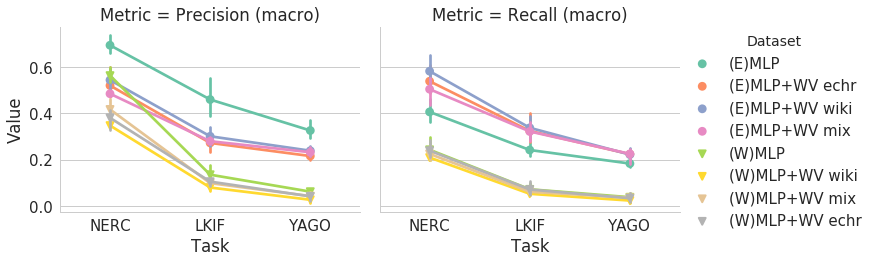

In [32]:
plot_datasets_all_tasks(all_evaluation_results , columns=['Prec(macro)', 'Rec(macro)'])

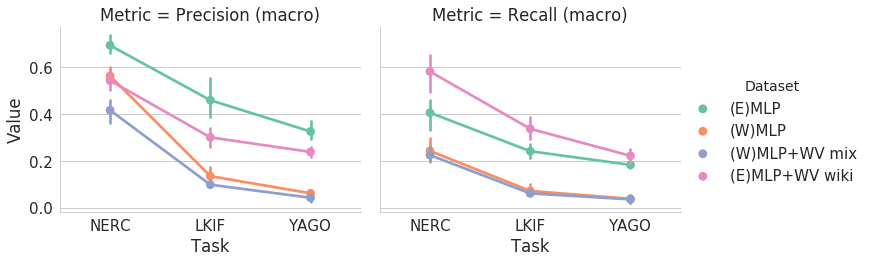

In [33]:
for x in all_evaluation_results:
    x.sort_index(inplace=True)
indexer = [slice(None)]*len(all_evaluation_results[0].index.names)
selected_datasets = [
    'handcrafted', 'wv_wiki', 'handcrafted_wiki_classifier', 'wv_mixed_wiki_classifier'
]
indexer[all_evaluation_results[0].index.names.index('Dataset')] = selected_datasets
to_graphic = [res.loc[tuple(indexer),:] for res in all_evaluation_results]
plot_datasets_all_tasks(to_graphic, columns=['Prec(macro)', 'Rec(macro)'])

Test results
====

In [107]:
dataset_names = [
    ('handcrafted', 'Handcrafted Features'),
    ('wv_echr', 'Word vectors trained with the ECHR documents'),
    ('wv_wiki', 'Word vectors trained with the Wikipedia documents'),
    ('wv_mixed', 'Word vectors trained with documents from Wikipedia and ECHR'),
    ('wv_google', 'Word vectors trained with documents from Wikipedia and ECHR')
]
prediction_base_filename = r'test_predictions_.*{}.*csv'
base_dirname = '../results/echr/evaluations/iter{i}/train/{{dataset_name}}'
all_test_results = get_fold_results(prediction_base_filename, dataset_names, base_dirname)

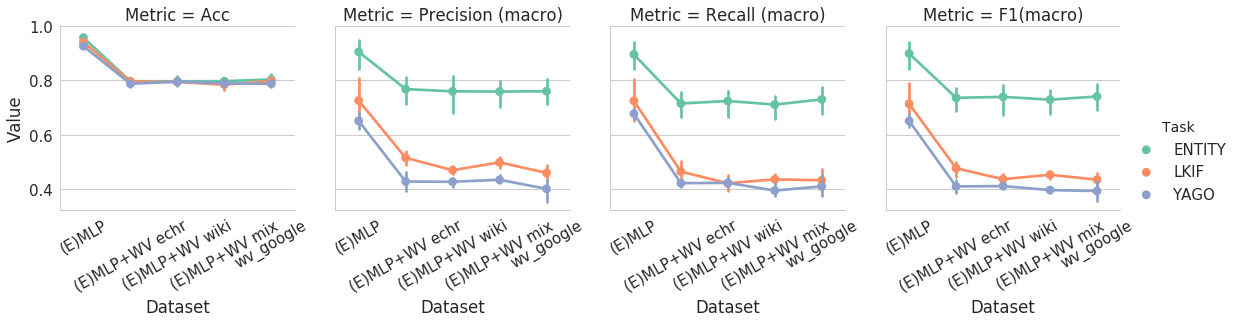

In [109]:
plot_tasks_all_datasets(all_test_results)

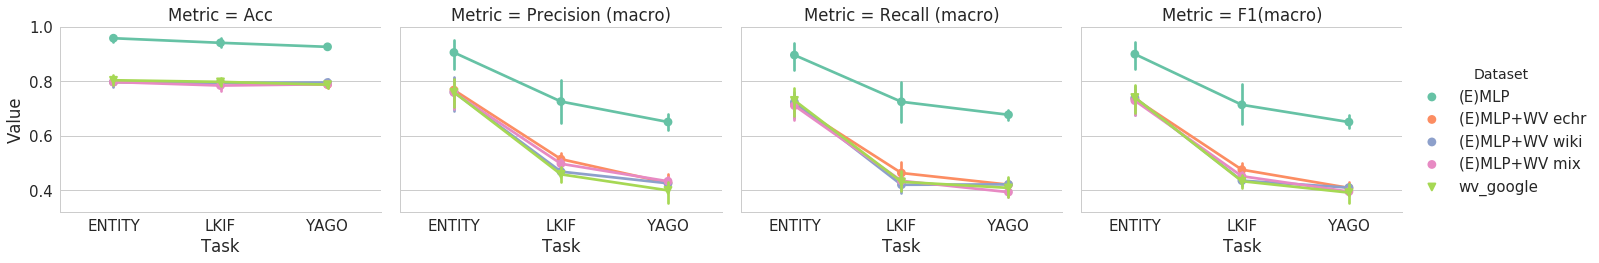

In [108]:
plot_datasets_all_tasks(all_test_results)

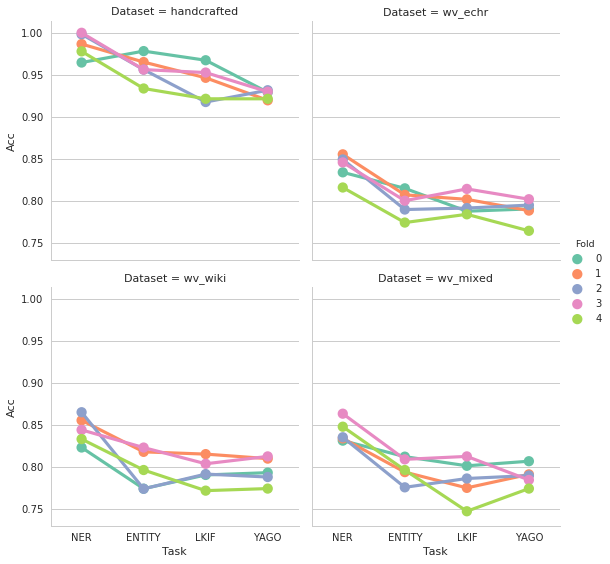

In [108]:
compare_iterations('Acc', all_test_results)

Evaluation results
===

In [28]:
dataset_names = [
    ('handcrafted', 'Handcrafted Features using the ECHR trained classifier'),
    ('wv_echr', 'Word vectors trained with the ECHR documents using the ECHR trained classifier'),
    ('wv_wiki', 'Word vectors trained with the Wikipedia documents using the ECHR trained classifier'),
    ('wv_mixed', 'Word vectors trained with documents from Wikipedia and ECHR using the ECHR trained classifier'),
    ('handcrafted_wiki_classifier', 'Handcrafted features using the Wikipedia trained classifier'),
    ('wv_wiki_wiki_classifier',
     'Word vectors trained with the Wikipedia documents using the Wikipedia trained classifier'),
    ('wv_mixed_wiki_classifier', ''),
    ('wv_echr_wiki_classifier', '')
]
evaluation_base_filename = r'evaluation_predictions_.*{}.*csv'
evaluation_base_dirname = '../results/echr/evaluations/iter{i}/train/{{dataset_name}}'
all_evaluation_results = get_fold_results(evaluation_base_filename, dataset_names, evaluation_base_dirname)

Error with iteration ENTITY and dataset handcrafted. ../results/echr/evaluations/iter3/train/handcrafted/evaluation_predictions_.*ENTITY.*csv
Error with iteration LKIF and dataset handcrafted. ../results/echr/evaluations/iter3/train/handcrafted/evaluation_predictions_.*LKIF.*csv
Error with iteration YAGO and dataset handcrafted. ../results/echr/evaluations/iter3/train/handcrafted/evaluation_predictions_.*YAGO.*csv
Error with iteration ENTITY and dataset wv_echr. ../results/echr/evaluations/iter3/train/wv_echr/evaluation_predictions_.*ENTITY.*csv
Error with iteration LKIF and dataset wv_echr. ../results/echr/evaluations/iter3/train/wv_echr/evaluation_predictions_.*LKIF.*csv
Error with iteration YAGO and dataset wv_echr. ../results/echr/evaluations/iter3/train/wv_echr/evaluation_predictions_.*YAGO.*csv
Error with iteration ENTITY and dataset wv_wiki. ../results/echr/evaluations/iter3/train/wv_wiki/evaluation_predictions_.*ENTITY.*csv
Error with iteration LKIF and dataset wv_wiki. ../resu

In [29]:
((all_evaluation_results[0] + all_evaluation_results[1] + all_evaluation_results[4]) / 3.0)[important_columns]

Acc Prec(macro) Rec(macro) F1(macro)
Dataset                     Task                                        
handcrafted                 ENTITY 0.81        0.69       0.41      0.47
                            LKIF   0.81        0.46       0.24      0.28
                            YAGO   0.81        0.33       0.18      0.21
wv_echr                     ENTITY 0.77        0.52       0.54      0.52
                            LKIF   0.75        0.27       0.32      0.27
                            YAGO   0.79        0.22       0.22      0.19
wv_wiki                     ENTITY 0.78        0.54       0.58      0.55
                            LKIF   0.79        0.30       0.34      0.29
                            YAGO   0.80        0.24       0.22      0.20
wv_mixed                    ENTITY 0.77        0.49       0.50      0.48
                            LKIF   0.77        0.28       0.32      0.28
                            YAGO   0.79        0.23       0.23      0.18
handcrafted_wiki_classifier ENTITY 0.76        0.56       0.24      0.26
                            LKIF   0.76        0.14       0.07      0.08
                            YAGO   0.76        0.06       0.04      0.04
wv_wiki_wiki_classifier     ENTITY 0.74        0.35       0.21      0.22
                            LKIF   0.75        0.08       0.05      0.05
                            YAGO   0.74        0.03       0.02      0.02
wv_mixed_wiki_classifier    ENTITY 0.75        0.42       0.23      0.23
                            LKIF   0.74        0.10       0.06      0.06
                            YAGO   0.75        0.04       0.04      0.03
wv_echr_wiki_classifier     ENTITY 0.75        0.38       0.24      0.24
                            LKIF   0.75        0.11       0.07      0.07
                            YAGO   0.74        0.04       0.03      0.03

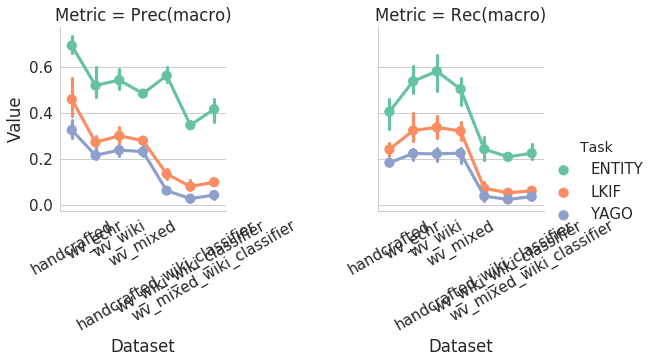

In [33]:
plot_tasks_all_datasets(all_evaluation_results, columns=['Prec(macro)', 'Rec(macro)'])

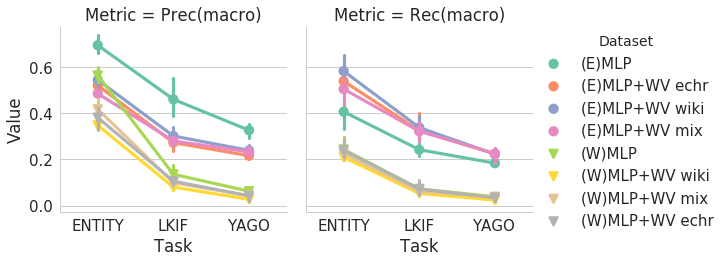

In [44]:
plot_datasets_all_tasks(all_evaluation_results , columns=['Prec(macro)', 'Rec(macro)'])

In [31]:
full_dataframes = [pandas.concat([x1, x2]) for x1, x2 in zip(all_evaluation_results, all_stanford_evaluation_results)]
plot_datasets_all_tasks(full_dataframes , columns=['Prec(macro)', 'Rec(macro)', 'F1(macro)'])

ValueError: Invalid RGBA argument: 0.40000000000000002

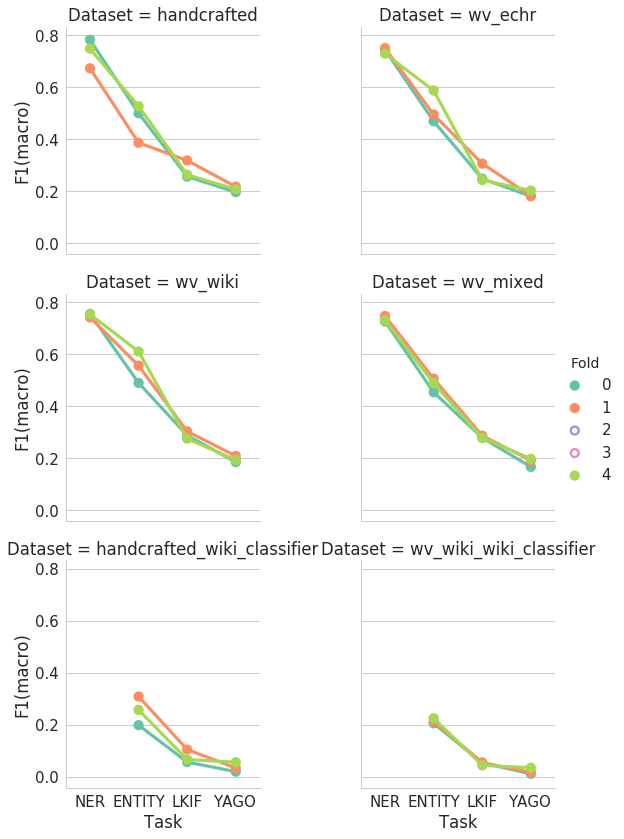

In [183]:
compare_iterations('F1(macro)', all_evaluation_results)

Stanford results
====

In [30]:
dataset_names = [
    ('stanford', ''),
    ('stanford_wiki_trained', ''),
]
evaluation_base_filename = r'.*{}-evaluation_results.csv'
evaluation_base_dirname = '../results/echr/evaluations/iter{i}/{{dataset_name}}'
stanford_iterations = ['entity', 'lkif', 'yago']
all_stanford_evaluation_results = get_fold_results(evaluation_base_filename, dataset_names, evaluation_base_dirname,
                                          iterations=stanford_iterations)

Error with iteration yago and dataset stanford_wiki_trained. ../results/echr/evaluations/iter1/stanford_wiki_trained/.*yago-evaluation_results.csv
Error with iteration yago and dataset stanford_wiki_trained. ../results/echr/evaluations/iter2/stanford_wiki_trained/.*yago-evaluation_results.csv
Error with iteration yago and dataset stanford_wiki_trained. ../results/echr/evaluations/iter3/stanford_wiki_trained/.*yago-evaluation_results.csv
Error with iteration yago and dataset stanford_wiki_trained. ../results/echr/evaluations/iter4/stanford_wiki_trained/.*yago-evaluation_results.csv
Error with iteration yago and dataset stanford_wiki_trained. ../results/echr/evaluations/iter5/stanford_wiki_trained/.*yago-evaluation_results.csv


/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [264]:
((all_stanford_evaluation_results[0] + all_stanford_evaluation_results[1] + all_stanford_evaluation_results[4]) / 3.0)[important_columns]

Acc Prec(macro) Rec(macro) F1(macro)
Dataset               Task                                         
stanford              entity 0.804       0.671      0.513     0.558
                      lkif   0.807       0.492      0.303     0.337
                      yago   0.799       0.288      0.214     0.208
stanford_wiki_trained entity 0.732       0.368      0.175     0.157
                      lkif   0.730       0.073      0.062     0.054
                      yago     NaN         NaN        NaN       NaN

In [249]:
all_stanford_evaluation_results[0]

Acc Prec(macro) Rec(macro) F1(macro)  \
Dataset               Task                                            
stanford              entity 0.823       0.706      0.523     0.587   
                      lkif   0.830       0.522      0.297     0.349   
                      yago   0.826       0.282      0.179     0.196   
stanford_wiki_trained entity 0.743       0.374      0.172     0.153   
                      lkif   0.740       0.078      0.057     0.051   
                      yago     NaN         NaN        NaN       NaN   

                             Prec(micro) Rec(micro) F1(micro) Prec(weighted)  \
Dataset               Task                                                     
stanford              entity       0.823      0.823     0.823          0.810   
                      lkif         0.830      0.830     0.830          0.818   
                      yago         0.826      0.826     0.826          0.784   
stanford_wiki_trained entity       0.743      0.743     0.743          0.626   
                      lkif         0.740      0.740     0.740          0.563   
                      yago           NaN        NaN       NaN            NaN   

                             Rec(weighted) F1(weighted) Top 20% Prec  \
Dataset               Task                                             
stanford              entity         0.823        0.808        0.856   
                      lkif           0.830        0.809        0.785   
                      yago           0.826        0.787        0.766   
stanford_wiki_trained entity         0.743        0.637        0.745   
                      lkif           0.740        0.632        0.247   
                      yago             NaN          NaN          NaN   

                             Bottom 20% Prec Top 20% Rec Bottom 20% Rec  \
Dataset               Task                                                
stanford              entity           0.373       0.949          0.191   
                      lkif             0.000       0.669          0.000   
                      yago             0.000       0.540          0.000   
stanford_wiki_trained entity           0.000       0.997          0.000   
                      lkif             0.000       0.332          0.000   
                      yago               NaN         NaN            NaN   

                             Top 20% F1 Bottom 20% F1  
Dataset               Task                             
stanford              entity      0.900         0.253  
                      lkif        0.712         0.000  
                      yago        0.574         0.000  
stanford_wiki_trained entity      0.853         0.000  
                      lkif        0.284         0.000  
                      yago          NaN           NaN

KNN Baseline results
---

In [88]:
dataset_names = [
    ('knn', 'Knn baseline'),
]
evaluation_base_filename = r'evaluation_predictions_{}.csv'
base_dirname = '../results/echr/evaluations/iter{i}/train/{dataset_name}'
knn_evaluation_results = get_fold_results(evaluation_base_filename, dataset_names, evaluation_base_dirname)

Error with iteration ENTITY and dataset knn. ../results/echr/evaluations/iter3/train/knn/evaluation_predictions_ENTITY.csv
Error with iteration LKIF and dataset knn. ../results/echr/evaluations/iter3/train/knn/evaluation_predictions_LKIF.csv
Error with iteration YAGO and dataset knn. ../results/echr/evaluations/iter3/train/knn/evaluation_predictions_YAGO.csv
Error with iteration ENTITY and dataset knn. ../results/echr/evaluations/iter4/train/knn/evaluation_predictions_ENTITY.csv
Error with iteration LKIF and dataset knn. ../results/echr/evaluations/iter4/train/knn/evaluation_predictions_LKIF.csv
Error with iteration YAGO and dataset knn. ../results/echr/evaluations/iter4/train/knn/evaluation_predictions_YAGO.csv


In [92]:
display((knn_evaluation_results[0] + knn_evaluation_results[1] + knn_evaluation_results[4])/3.0)

Acc Prec(macro) Rec(macro) F1(macro) Prec(micro) Rec(micro)  \
Dataset Task                                                                  
knn     ENTITY 0.73        0.56       0.49      0.50        0.73       0.73   
        LKIF   0.73        0.32       0.27      0.25        0.73       0.73   
        YAGO   0.72        0.22       0.18      0.16        0.72       0.72   

               F1(micro) Prec(weighted) Rec(weighted) F1(weighted)  \
Dataset Task                                                         
knn     ENTITY      0.73           0.77          0.73         0.74   
        LKIF        0.73           0.77          0.73         0.73   
        YAGO        0.72           0.77          0.72         0.73   

               Top 20% Prec Bottom 20% Prec Top 20% Rec Bottom 20% Rec  \
Dataset Task                                                             
knn     ENTITY         0.85            0.36        0.82           0.35   
        LKIF           0.67            0.04        0.63           0.08   
        YAGO           0.59            0.00        0.42           0.00   

               Top 20% F1 Bottom 20% F1  
Dataset Task                             
knn     ENTITY       0.84          0.36  
        LKIF         0.61          0.06  
        YAGO         0.44          0.00

Wikipedia + ECHR Word Embeddings
===

In [19]:
dataset_names = [
    ('wiki_wv_mixed', '')
]
prediction_base_filename = r'test_predictions_.*{}.*csv'
base_dirname = '../results/{dataset_name}'
test_results = get_results(prediction_base_filename, dataset_names, base_dirname)

In [20]:
test_results

Acc Prec(macro) Rec(macro) F1(macro) Prec(micro)  \
Dataset       Task                                                        
wiki_wv_mixed ENTITY 0.927       0.917      0.741     0.793       0.927   
              LKIF   0.909       0.757      0.595     0.642       0.909   
              YAGO   0.885       0.758      0.533     0.599       0.885   

                     Rec(micro) F1(micro) Prec(weighted) Rec(weighted)  \
Dataset       Task                                                       
wiki_wv_mixed ENTITY      0.927     0.927          0.927         0.927   
              LKIF        0.909     0.909          0.908         0.909   
              YAGO        0.885     0.885          0.884         0.885   

                     F1(weighted) Top 20% Prec Bottom 20% Prec Top 20% Rec  \
Dataset       Task                                                           
wiki_wv_mixed ENTITY        0.926        0.942           0.970       0.918   
              LKIF          0.908        0.898           0.300       0.899   
              YAGO          0.883        0.857           0.474       0.799   

                     Bottom 20% Rec Top 20% F1 Bottom 20% F1  
Dataset       Task                                            
wiki_wv_mixed ENTITY          0.287      0.930         0.443  
              LKIF            0.146      0.899         0.163  
              YAGO            0.202      0.823         0.253

In [21]:
dataset_names = [
    ('word_vectors', ''),
    ('handcrafted', ''),
]
prediction_base_filename = r'test_predictions_.*{}.*csv'
base_dirname = '/home/ccardellino/datasets/predictions/{dataset_name}/batch'
test_results = get_results(prediction_base_filename, dataset_names, base_dirname)

In [22]:
test_results

Acc Prec(macro) Rec(macro) F1(macro) Prec(micro)  \
Dataset      Task                                                        
word_vectors ENTITY 0.942       0.858      0.804     0.828       0.942   
             LKIF   0.926       0.687      0.616     0.637       0.926   
             YAGO   0.901       0.678      0.610     0.629       0.901   
handcrafted  ENTITY 0.990       0.909      0.858     0.879       0.990   
             LKIF   0.971       0.744      0.670     0.699       0.971   
             YAGO   0.950       0.762      0.646     0.689       0.950   

                    Rec(micro) F1(micro) Prec(weighted) Rec(weighted)  \
Dataset      Task                                                       
word_vectors ENTITY      0.942     0.942          0.942         0.942   
             LKIF        0.926     0.926          0.926         0.926   
             YAGO        0.901     0.901          0.900         0.901   
handcrafted  ENTITY      0.990     0.990          0.990         0.990   
             LKIF        0.971     0.971          0.970         0.971   
             YAGO        0.950     0.950          0.950         0.950   

                    F1(weighted) Top 20% Prec Bottom 20% Prec Top 20% Rec  \
Dataset      Task                                                           
word_vectors ENTITY        0.942        0.949           0.639       0.940   
             LKIF          0.925        0.912           0.059       0.928   
             YAGO          0.900        0.853           0.382       0.825   
handcrafted  ENTITY        0.990        1.000           0.768       1.000   
             LKIF          0.970        0.962           0.177       0.966   
             YAGO          0.950        0.894           0.498       0.879   

                    Bottom 20% Rec Top 20% F1 Bottom 20% F1  
Dataset      Task                                            
word_vectors ENTITY          0.488      0.945         0.553  
             LKIF            0.101      0.920         0.064  
             YAGO            0.301      0.837         0.318  
handcrafted  ENTITY          0.506      1.000         0.610  
             LKIF            0.147      0.964         0.149  
             YAGO            0.349      0.886         0.394